In [1]:
# Ideas generales
# Cargar ligandos_
# cocristalizados
# CSAR
# DUD
# DEKOIS

# Identificarlos como activos o inactivos

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os, pickle

from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [20:01:58] Enabling RDKit 2019.09.1 jupyter extensions


In [3]:
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')

In [4]:
def load_molecules_from_dir(list_of_sdf_files):
    '''Function to load molecules from sdf files using rdkit'''
    # Load the molecules in a dictionary
    mols_dict = {}
    sanitized = True
    for sdf_file in list_of_sdf_files:
        # Get the molecule name
        mol_name = sdf_file.split('/')[-1].split('.')[0]
        # Try to load the molecule with sanitize = True
        mol_rd = Chem.SDMolSupplier(sdf_file, sanitize = True)[0]
        if mol_rd is None:
            mol_rd = Chem.SDMolSupplier(sdf_file, sanitize = False)[0]
            mol_rd.UpdatePropertyCache(strict = False)
            sanitized = False
        mols_dict[mol_name] = [mol_rd, sanitized]
    return mols_dict

def get_files_list(path_to_sdfs, actives_name = 'ligand', inactives_name = 'decoy'):
    # Active molecules
    file_list_ACTIVES = glob(path_to_sdfs + F'/{actives_name}*')
    file_list_ACTIVES.sort(key = lambda x: 
                        int(x.split('/')[-1].split('.')[0].split('_')[1]) )
    # Inactive molecules
    file_list_INACTIVES = glob(path_to_sdfs + F'/{inactives_name}*')
    file_list_INACTIVES.sort(key = lambda x: 
                        int(x.split('/')[-1].split('.')[0].split('_')[1]) )
    # Join both list
    file_list = file_list_ACTIVES + file_list_INACTIVES
    return file_list

def get_mol_dataframe(mol_dictionary):
    # Convert to a dataframe
    df = pd.DataFrame(mol_dictionary).T
    df.columns = ['mol_rdk', 'sanitized']
    # Activity inactivity column
    act_inact = ['active' if i[:6] == 'ligand' else 'inactive' for i in df.index]
    df['Activity'] = act_inact
    # Naming the columns
    df = df[['Activity', 'mol_rdk', 'sanitized']]
    return df


## Cocristalized ligands
### Read the cocrystalized ligands
Previously, in notebook `1_Working_with_3D_structures_in_rdkit` we have saved a python object containing a dataframe with the cocristalized ligands. That dataframe is the following:

In [5]:
path_to_file_cocrys = os.path.join(*F'../data/rdkit_molecules/cdk2_365_cocristalized_ligands.pyobj'.split('/'))
with open(path_to_file_cocrys, 'rb') as f:
    df_crys_poses_rdk = pickle.load(f)
df_crys_poses_rdk.head()

,Lig,mol_rdk,file,Labels_conf,Validation
1aq1,STU,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a82f0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_b,v1
1b38,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a8330>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1b39,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a83b0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1ckp,PVB,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a8430>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1di8,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a84b0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1


From this dataframe we are only interested in the ligand name, and in the `mol_rd` columns, which has the *rdkit* molecule instances. W also need to add column indicating that the ligand is an **Active**, or Inactive, ligand. Of course because these molecules were cocristalized with the protein we're going to assume all of them are actives.  

Also, we are going to remove duplicate ligands, mainly because for this analysis we are not interested in the 3D conformation. **At the end we only going to keep 315 ligands from the original 365**.

In [6]:
df_COCRYS = df_crys_poses_rdk.reset_index()[['Lig', 'mol_rdk']]
df_COCRYS.drop_duplicates(subset = 'Lig', inplace = True)
df_COCRYS.set_index('Lig', inplace = True)
df_COCRYS['Activity'] = 'active'
df_COCRYS['sanitized'] = True
df_COCRYS = df_COCRYS[['Activity', 'mol_rdk', 'sanitized']]
df_COCRYS.shape

(315, 3)

In [7]:
df_COCRYS.head()

,Activity,mol_rdk,sanitized
Lig,,,
STU,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a82f0>,True
ATP,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a8330>,True
PVB,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a8430>,True
DTQ,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a84b0>,True
HMD,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c22a8530>,True


## CSAR dataset
### Read the CSAR dataset molecules

In [69]:
# File of the python object
csar_obj_file = os.path.join(*F'../data/rdkit_molecules/cdk2_CSAR_ligands.pyobj'.split('/'))

if os.path.isfile(csar_obj_file):
    with open(csar_obj_file, 'rb') as f:
        df_CSAR = pickle.load(f)

else:
    # Firs we got the molecules dictionary
    path_to_file_csar_sdfs = \
    os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/CSAR/sdf/*'.split('/'))
    csar_file_list = glob(path_to_file_csar_sdfs)
    # sort alphanumericalñy
    csar_file_list.sort(key = lambda x: int(x.split('/')[-1].split('.')[0].replace('CS', '')))

    # Load the molecules using the function previously declared
    csar_molecules_dic = load_molecules_from_dir(csar_file_list)
    # Convert to a dataframe
    df_CSAR = pd.DataFrame(csar_molecules_dic).T
    df_CSAR.columns = ['mol_rdk', 'sanitized']
    # The information about if the molecule is active or inactive is in the following file
    df_csar_activity = pd.read_json('../data/csar_Binding_Data_Corrected_2016.json')
    # merge both dataframes
    df_CSAR['Activity'] = df_csar_activity['ActiveInactive'].str.lower()
    # Naming the columns
    df_CSAR = df_CSAR[['Activity', 'mol_rdk', 'sanitized']]
    
    # Save the file
    with open(csar_obj_file, 'wb') as f:
        pickle.dump(df_CSAR, f)

In [70]:
df_CSAR.head()

,Activity,mol_rdk,sanitized
CS1,active,<rdkit.Chem.rdchem.Mol object at 0x7f21bd4b3ef0>,True
CS2,active,<rdkit.Chem.rdchem.Mol object at 0x7f21bd4b37f0>,True
CS3,active,<rdkit.Chem.rdchem.Mol object at 0x7f21bd4b3f70>,True
CS4,active,<rdkit.Chem.rdchem.Mol object at 0x7f21bd4b35b0>,True
CS5,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f21bd4b3eb0>,True


## DUD 2006 Dataset

In [10]:
dud_obj_file = os.path.join(*F'../data/rdkit_molecules/cdk2_DUD_ligands.pyobj'.split('/'))

if os.path.isfile(dud_obj_file):
    with open(dud_obj_file, 'rb') as f:
        df_DUD = pickle.load(f)

else:
    # Firs we got the molecules dictionary
    path_to_file_dud_sdfs = \
    os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/sdf/'.split('/'))
    # Get the files list
    dud_file_list = get_files_list(path_to_sdfs = path_to_file_dud_sdfs, 
                                   actives_name='ligand', inactives_name='decoy')

    # Load the molecules using the function previously declared
    # load_molecules_from_dir(path_to_file_csar_sdfs)
    dud_molecules_dic = load_molecules_from_dir(dud_file_list)

    # Convert to a dataframe
    df_DUD = get_mol_dataframe(mol_dictionary=dud_molecules_dic)
    
    with open(dud_obj_file, 'wb') as f:
        pickle.dump(df_DUD, f)

In [11]:
df_DUD.head()

,Activity,mol_rdk,sanitized
ligand_1,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c222e730>,True
ligand_2,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21d7130>,True
ligand_3,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21d7170>,True
ligand_4,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21d71b0>,True
ligand_5,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21d71f0>,True


## DEKOIS Dataset

In [12]:
dekois_obj_file = os.path.join(*F'../data/rdkit_molecules/cdk2_DEKOIS_ligands.pyobj'.split('/'))

if os.path.isfile(dekois_obj_file):
    with open(dekois_obj_file, 'rb') as f:
        df_DEKOIS = pickle.load(f)

else:
    # Firs we got the molecules dictionary
    path_to_file_dekois_sdfs = \
    os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/DEKOIS_2/sdf/'.split('/'))
    # Get the files list
    dekois_file_list = get_files_list(path_to_sdfs = path_to_file_dekois_sdfs, 
                                   actives_name='ligand', inactives_name='decoy')

    # Load the molecules using the function previously declared
    # load_molecules_from_dir(path_to_file_csar_sdfs)
    dekois_molecules_dic = load_molecules_from_dir(dekois_file_list)

    # Convert to a dataframe
    df_DEKOIS = get_mol_dataframe(mol_dictionary=dekois_molecules_dic)
    
    with open(dekois_obj_file, 'wb') as f:
        pickle.dump(df_DEKOIS, f)

In [13]:
df_DEKOIS.head()

,Activity,mol_rdk,sanitized
ligand_1,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21d70f0>,True
ligand_2,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21bb7f0>,True
ligand_3,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21bb830>,True
ligand_4,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21bb870>,True
ligand_5,active,<rdkit.Chem.rdchem.Mol object at 0x7f21c21bb8b0>,True


## List of Datasets

In [72]:
lig_datasets = {'COCRYS': df_COCRYS, 'CSAR': df_CSAR, 'DUD': df_DUD, 'DEKOIS': df_DEKOIS}

## Molecular Weight and Num. Heavy Atoms

In [74]:
from rdkit.Chem import Descriptors, Lipinski

In [75]:
# Get the molecular weight and # of heavy atoms for each ligand

for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]

## Fingerprints

In [76]:
for dataset in lig_datasets.values():
    # molecular weight
    dataset['fps'] = [Chem.RDKFingerprint(i) for i in dataset['mol_rdk']]

## Histograms

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

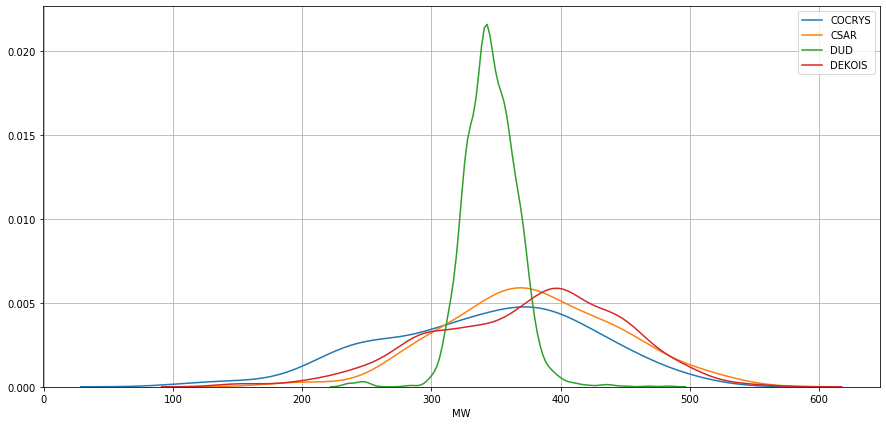

In [77]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    sns.distplot(dataset['MW'], label = name, hist = False, bins = 30 )
plt.grid()

In [82]:
for name, dataset in lig_datasets.items():
    df = dataset[dataset['Activity'] == 'active']
    print(len(df))

315
26
72
40


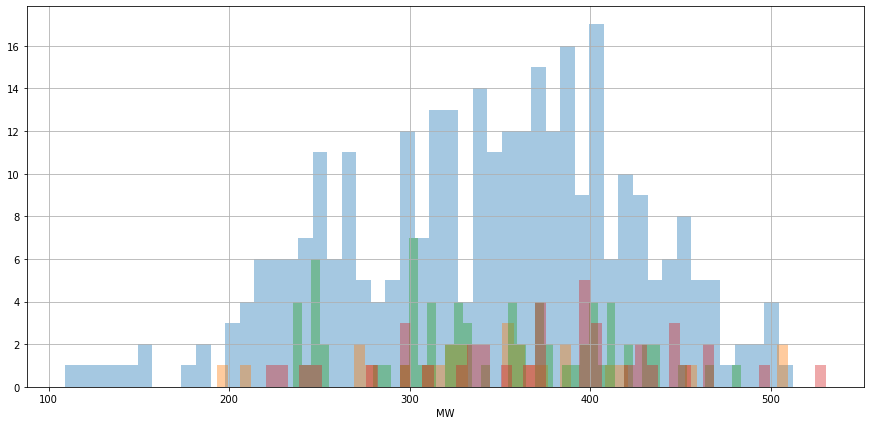

In [87]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    df = dataset[dataset['Activity'] == 'active']
    sns.distplot(df['MW'], label = name, kde = False, bins = 50 )
plt.grid()

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


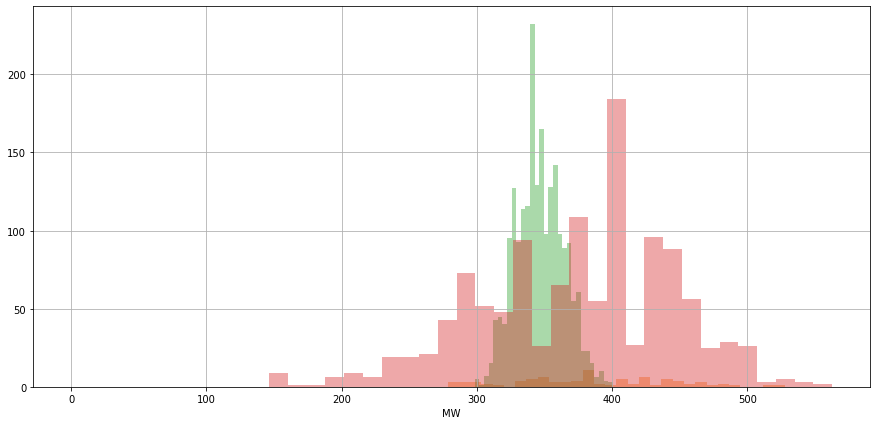

In [88]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    df = dataset[dataset['Activity'] == 'inactive']
    sns.distplot(df['MW'], label = name, kde = False, bins = 30 )
plt.grid()

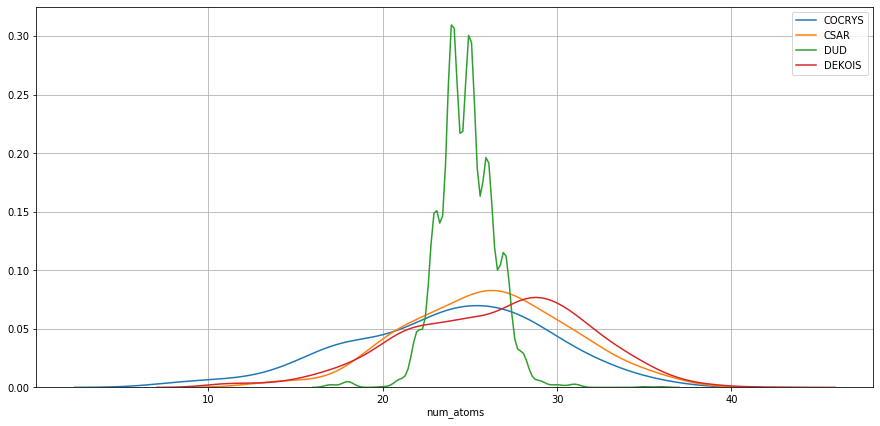

In [52]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    sns.distplot(dataset['num_atoms'], label = name, hist = False, bins = 30)
plt.grid()

## Tanimoto similarity

In [133]:
from rdkit.DataStructs import FingerprintSimilarity
from itertools import combinations

In [145]:
for key_i, key_j in combinations(lig_datasets.keys(), 2):
    print('\n' + '='*20)
    print(key_i, '\t', key_j)
    print('='*15)
    d_i = lig_datasets[key_i]
    d_j = lig_datasets[key_j]
    
    for k in d_i.index:
        for p in d_j.index:
            fp_sim = FingerprintSimilarity(
                d_i.loc[k, 'fps'], 
                d_j.loc[p, 'fps'])
            
            if fp_sim >= 0.95:
                print(k, '\t', p)


COCRYS 	 CSAR
CK2 	 CS12
N5B 	 CS3
18K 	 CS18
1CK 	 CS1
03K 	 CS3
09K 	 CS9
11K 	 CS11
20K 	 CS20
42K 	 CS242
60K 	 CS260
61K 	 CS261
62K 	 CS262

COCRYS 	 DUD
CMG 	 ligand_2
NW1 	 ligand_66
NW1 	 ligand_67
1PU 	 ligand_24
MBP 	 ligand_34
MBP 	 ligand_35
UN4 	 ligand_40
UN4 	 ligand_41
2A6 	 ligand_44
2A6 	 ligand_45
6CP 	 ligand_42
6CP 	 ligand_43
4SP 	 ligand_9
LS1 	 ligand_21
LS4 	 ligand_23
ST8 	 ligand_27
N20 	 ligand_44
N20 	 ligand_45
UCN 	 ligand_15
UCN 	 ligand_16
OLO 	 ligand_11
RRC 	 ligand_12
D42 	 ligand_64
D42 	 ligand_65
F9Z 	 ligand_69

COCRYS 	 DEKOIS
CMG 	 ligand_37
1PU 	 ligand_27
1CD 	 decoy_37
F9Z 	 ligand_38

CSAR 	 DUD
CS241 	 ligand_71

CSAR 	 DEKOIS

DUD 	 DEKOIS
ligand_2 	 ligand_37
ligand_14 	 ligand_22
ligand_15 	 ligand_3
ligand_24 	 ligand_27
ligand_69 	 ligand_38
decoy_390 	 decoy_610
decoy_391 	 decoy_610
decoy_412 	 decoy_610
decoy_413 	 decoy_610
decoy_414 	 decoy_610
decoy_415 	 decoy_610
decoy_535 	 decoy_106
decoy_536 	 decoy_106
decoy_546 	 decoy_